**Dataset Linki**
**https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing**

**1. Kütüphanelerin Yüklenmesi**

In [ ]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install tensorflow-io
!pip install matplotlib


In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

**2.Veri Yükleme**

In [2]:
CAPUCHIN_FILE=os.path.join('data','Parsed_Capuchinbird_Clips','XC3776-0.wav')
NOT_CAPUCHIN_FILE=os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

In [3]:
def load_wav_16k_mono(file):
    file_contents=tf.io.read_file(file)
    # Üstte sesi okuyup altta decode ediyor
    wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)

    wav=tf.squeeze(wav,axis=-1)

    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    #Sinyal 44100Hzden 16000Hz'e azaltarak datayı azaltıyoruz
    wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav

**Deneme Yeri**

In [4]:
file_contents=tf.io.read_file(CAPUCHIN_FILE)
file_contents
wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
print(wav.shape)
print(sample_rate)
wav=tf.squeeze(wav,axis=-1)
sample_rate=tf.cast(sample_rate,dtype=tf.int64)
wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
wav


(132300, 1)
tf.Tensor(44100, shape=(), dtype=int32)


<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 1.0432389e-06, -3.0215922e-06,  1.9820709e-06, ...,
       -4.5542806e-02, -5.4887902e-02, -8.5778177e-02], dtype=float32)>

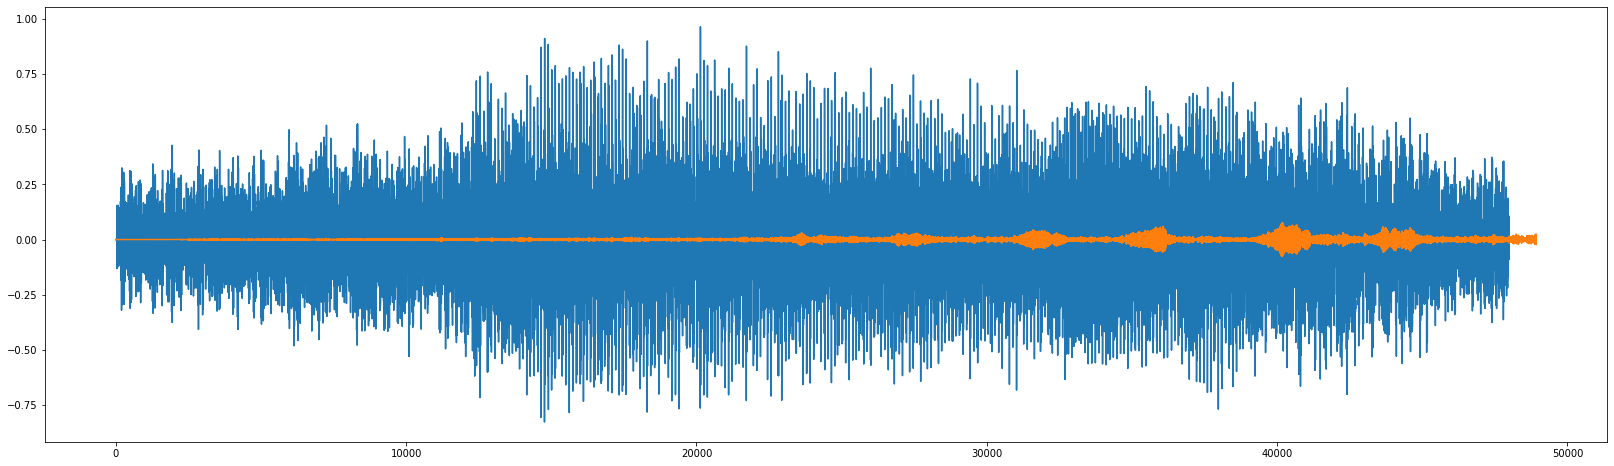

In [5]:
plt.figure(figsize=(28,8))
plt.plot(load_wav_16k_mono(CAPUCHIN_FILE))
plt.plot(load_wav_16k_mono(NOT_CAPUCHIN_FILE))

**3.Spectograma Dönüştürme**

In [6]:
POS=os.path.join('data','Parsed_Capuchinbird_Clips')
NEG=os.path.join('data','Parsed_Not_Capuchinbird_Clips')
pos=tf.data.Dataset.list_files(POS+'\*.wav')
neg=tf.data.Dataset.list_files(NEG+'\*.wav')

pos.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC495697-1.wav'

In [7]:
positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data=positives.concatenate(negatives)
#Denemeler
positives.as_numpy_iterator().next()
negatives.as_numpy_iterator().next()
data.as_numpy_iterator().next()

(b'data\\Parsed_Capuchinbird_Clips\\XC227469-3.wav', 1.0)

In [8]:
lengths=[]
for f in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
    tensor_wave=load_wav_16k_mono(os.path.join('data','Parsed_Capuchinbird_Clips',f))
    lengths.append(len(tensor_wave))

In [9]:
lengths

[40000,
 48000,
 56000,
 48000,
 56000,
 64000,
 64000,
 64000,
 56000,
 56000,
 48000,
 56000,
 64000,
 56000,
 40000,
 64000,
 64000,
 64000,
 64000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 56000,
 56000,
 64000,
 64000,
 48000,
 56000,
 64000,
 56000,
 64000,
 32000,
 40000,
 48000,
 40000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 64000,
 64000,
 48000,
 64000,
 48000,
 48000,
 40000,
 48000,
 48000,
 56000,
 56000,
 48000,
 40000,
 56000,
 48000,
 40000,
 56000,
 48000,
 48000,
 56000,
 48000,
 64000,
 64000,
 40000,
 40000,
 72000,
 56000,
 56000,
 56000,
 64000,
 56000,
 64000,
 64000,
 56000,
 56000,
 56000,
 48000,
 48000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 40000,
 64000,
 56000,
 56000,
 40000,
 64000,
 56000,
 64000,
 48000,
 64000,
 56000,
 48000,
 48000,
 48000,
 64000,
 64000,
 64000,
 48000,
 48000,
 56000,
 48000,
 64000,
 48000,
 64000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 40000,
 48000,
 48000,


In [10]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [11]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [12]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [13]:
print(f'mean: {54156/16000}, min: {32000/16000}, max: {80000/16000}')

mean: 3.38475, min: 2.0, max: 5.0


In [14]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

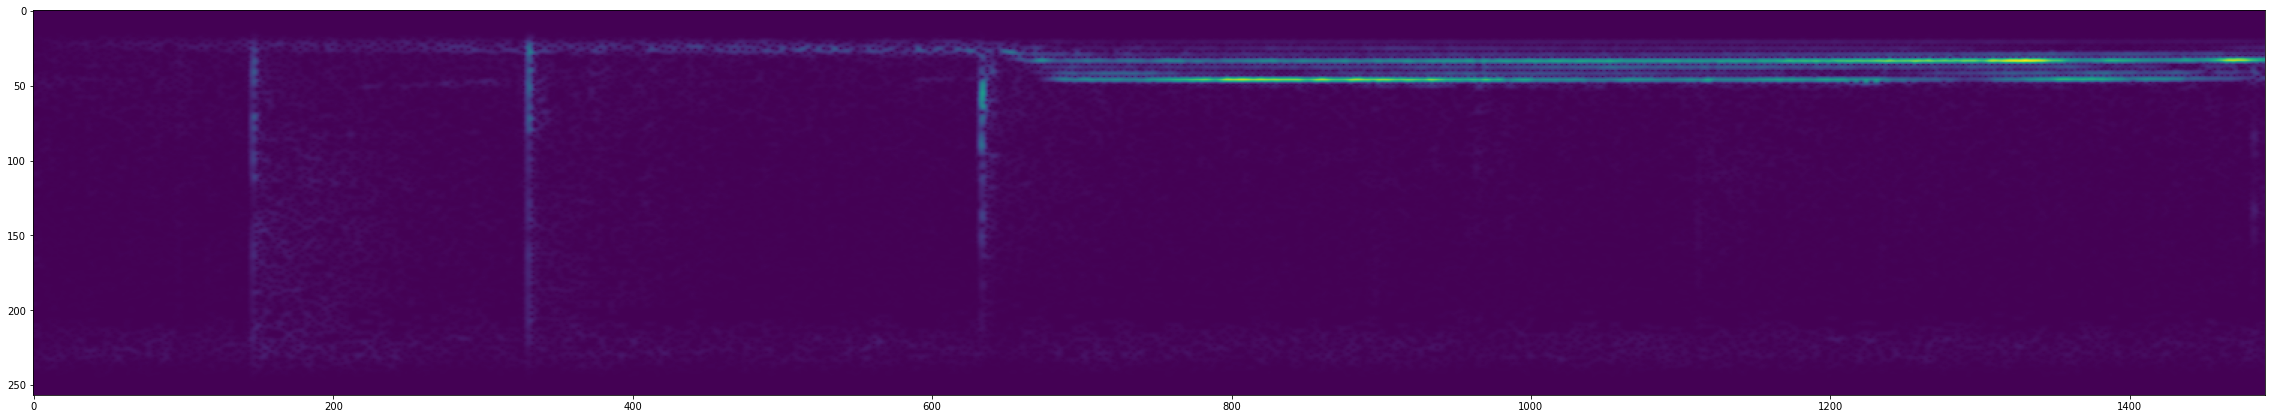

In [16]:
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(40,40))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

**4.Eğitim ve Test Ayrıştırması**

In [17]:
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16).prefetch(8)

In [18]:
train=data.take(36)
test=data.skip(36).take(15)

In [19]:
samples,labels=train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [20]:
print(labels.shape)
labels

(16,)


array([1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

**5.Modelin Oluşturulması**

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [24]:
model=Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1491,257,1)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

ResourceExhaustedError: OOM when allocating tensor with shape[6019376,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
model.compile(optimizer='Adam')

In [26]:
!pip list

Package                      Version
---------------------------- ------------------------
absl-py                      1.0.0
appdirs                      1.4.4
asttokens                    2.0.5
astunparse                   1.6.3
audioread                    2.1.9
backcall                     0.2.0
beautifulsoup4               4.9.3
bs4                          0.0.1
cachetools                   5.0.0
certifi                      2021.10.8
cffi                         1.15.0
chardet                      4.0.0
charset-normalizer           2.0.12
click                        8.1.2
cloudpickle                  2.0.0
colorama                     0.4.4
comtypes                     1.1.11
cycler                       0.11.0
debugpy                      1.6.0
decorator                    5.1.1
deep-translator              1.8.3
entrypoints                  0.4
executing                    0.8.3
filelock                     3.6.0
flatbuffers                  2.0
fonttools                    4